<a href="https://colab.research.google.com/github/smonobig/laba_1/blob/main/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
!pip install GPyOpt --index-url=https://pypi.org/simple/
!pip install catboost
!pip install shap

import catboost
import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

Looking in indexes: https://pypi.org/simple/


In [ ]:
data = pd.read_csv("/content/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


## Сколько % пропущенных значений есть для каждого признака?

In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

**NaN-значения**

In [ ]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [ ]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

In [ ]:
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

In [ ]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


Цена и количество записей без идентификатора клиента могут сильно отличаться. Чтобы выяснить есть ли скрытые NaN - значения в Description, создадим новую функцию, которая будет содержать описания в нижнем регистре.

Нахождения NaN-столбцов в Description

In [ ]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

#Нахождение пустых"" строк

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

Были обнаружены дополнительные скрытые значения nan, которые показывают строку «nan» вместо значения nan. Необходимо преобразовать их в NaN

In [ ]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

Поскольку не известно, почему отсутствуют клиенты или описания, и были видны при исследовании странные отклонения в количествах и ценах, а также нулевые цены, необходимо быть осторожным и отбросить все эти случаи.

In [ ]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

Проверка остатков не корректных значений

In [ ]:
data.isnull().sum().sum()

0

На каком временном промежутке были собраны данные

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


Сколько различных Invoice№ есть в DataSete

In [ ]:
data.InvoiceNo.nunique()

22186

Транзакции, начинающий с буквы С значатся как отмененные, дабы вычисления были корректные, найдем и отрбросим их

In [ ]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

In [ ]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice
count,8896.000000,8896.000000
mean,-30.882981,18.862815
std,1170.746458,444.590459
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Все отмены имеют отрицательные количества, но положительные, ненулевые цены за единицу. Учитывая эти данные, нелегко понять, почему клиент совершил возврат, и очень сложно предсказать такие случаи, поскольку может быть несколько скрытых причин, по которым была произведена отмена. Уберем их из дата сета

In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

Сколько уникальных StockCode в этом дата сете

In [ ]:
data.StockCode.nunique()

3663

Какие StockCode являются наиболее ходовыми

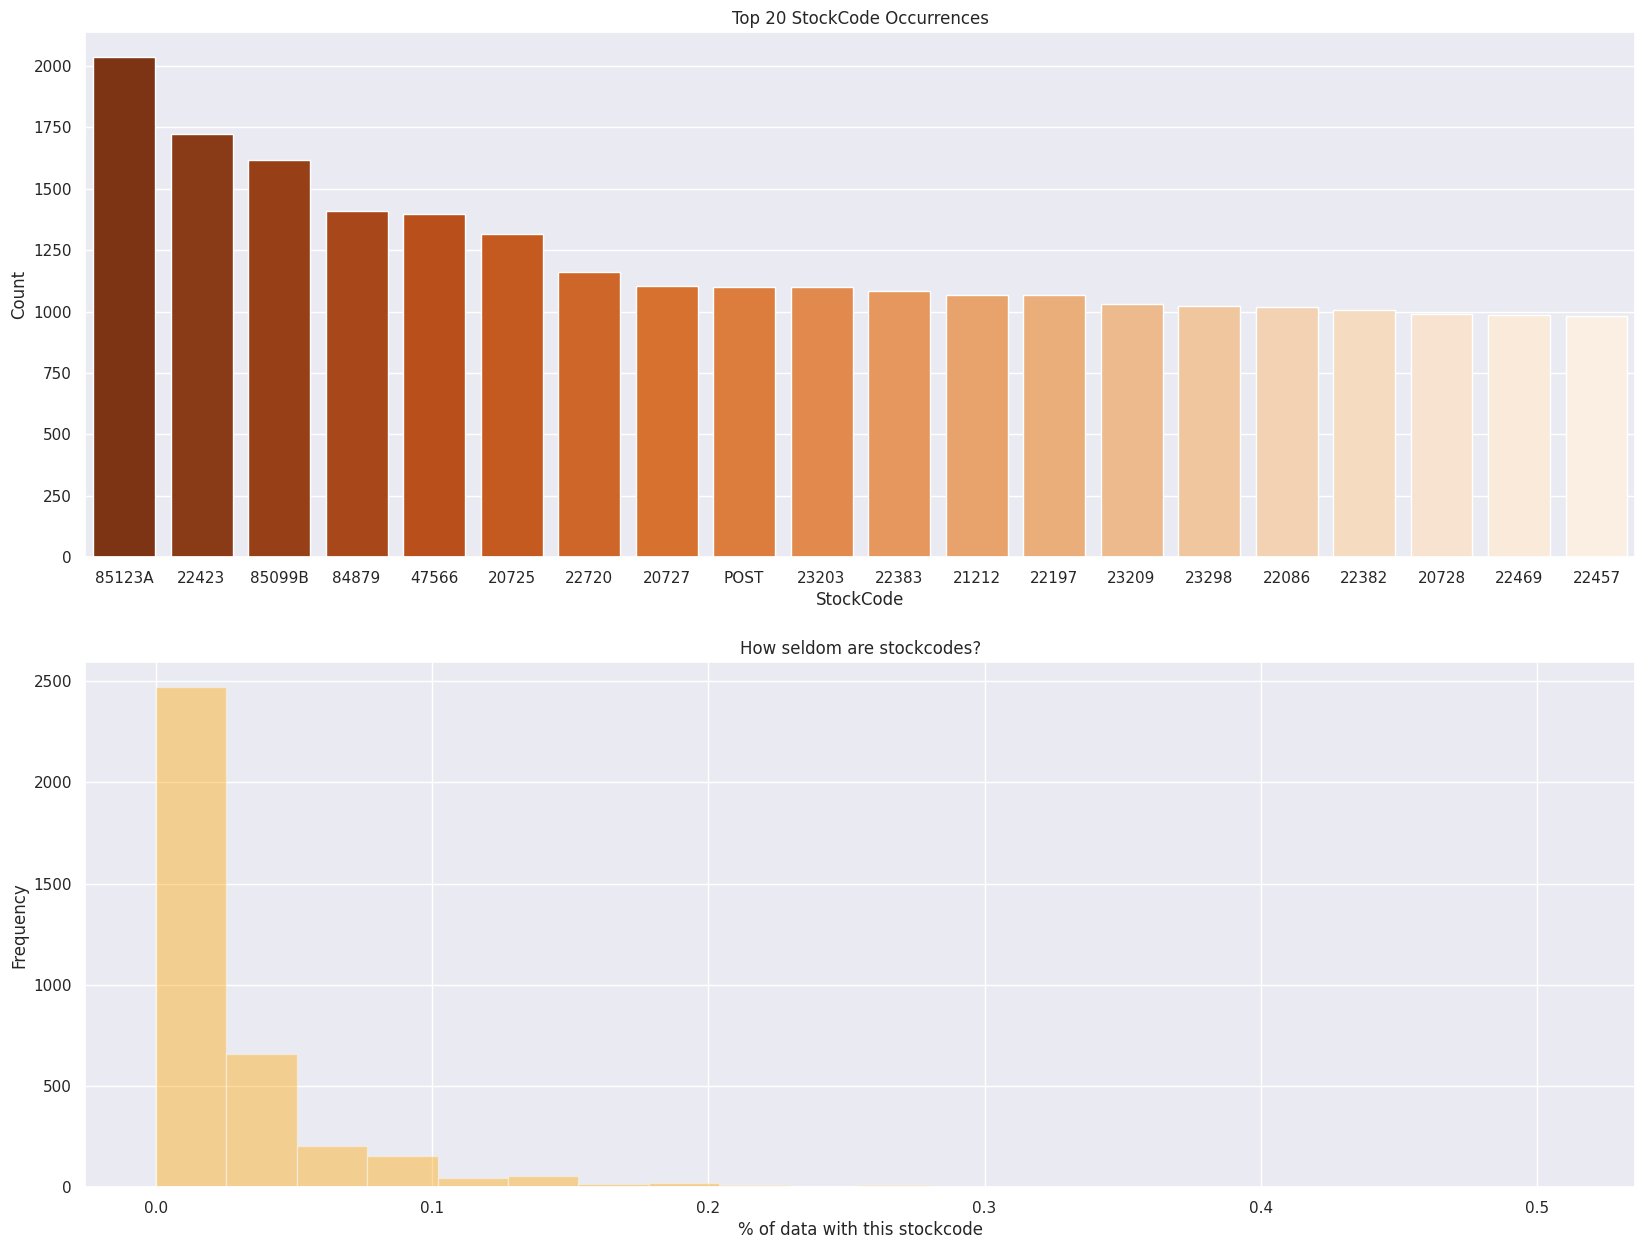

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")

ax[0].set_title('Top 20 StockCode Occurrences')
ax[0].set_xlabel('StockCode')
ax[0].set_ylabel('Count')

sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

Большинство StockCode встречаются очень редко. Это указывает на то, что розничный торговец продает множество различных продуктов и что у него нет строгой секиализации определенного складского кода. Тем не менее, необходимо быть осторожны, поскольку это не должно означать, что розничный торговец не специализируется на конкретном типе продукта.

Подсчёт количества числовых символов и длина StockCode

In [ ]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

Несмотря на то, что большинство образцов имеют StockCode, состоящий из 5 цифровых символов, видно, что есть и другие случаи. Длина может варьироваться от 1 до 12, а некоторые биржевые коды вообще не содержат числовых символов.

In [ ]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [ ]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [ ]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

Сколько уникальных Description в дата сете

In [ ]:
data.Description.nunique()

2983

Наиболее ходовые Description

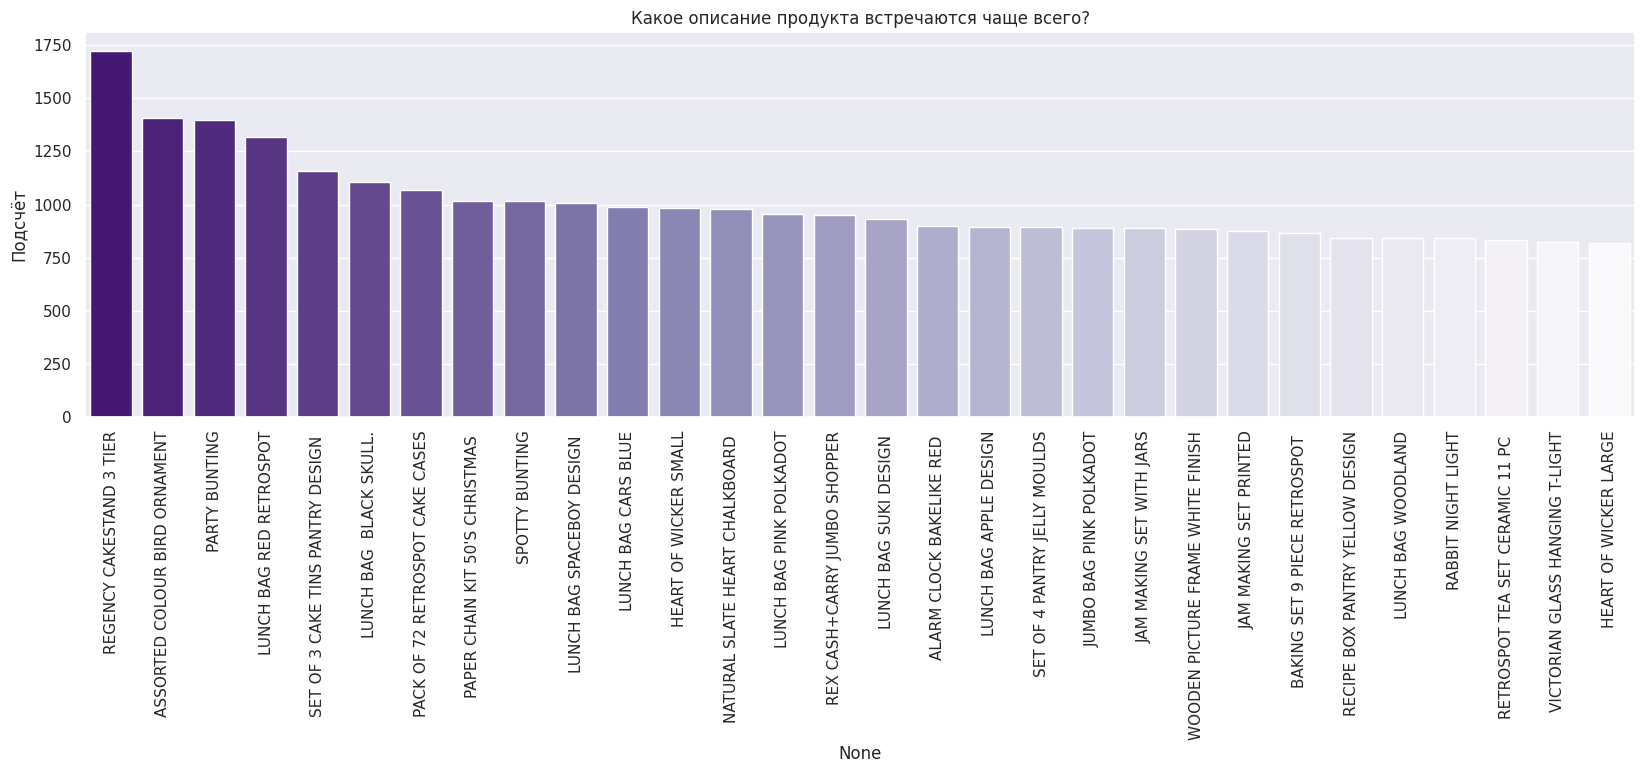

In [ ]:
description_counts = data['Description'].value_counts().sort_values(ascending=False).iloc[0:30]

# Plot the top 30 occurrences using Seaborn's barplot
plt.figure(figsize=(20, 5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")

plt.ylabel("Подсчёт")
plt.title("Какое описание продукта встречаются чаще всего?")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

plt.show()

Некоторые описания соответствуют одному и тому же типу продукта. Также часто есть информация о цвете продукта. Более того, наиболее распространенные описания, похоже, подтверждают, что розничный торговец продает различные виды товаров. Кажется, что все описания состоят из символов верхнего регистра. Теперь проведем дополнительный анализ описаний, посчитав длину и количество символов нижнего регистра.

In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [ ]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

Description упорядочены.

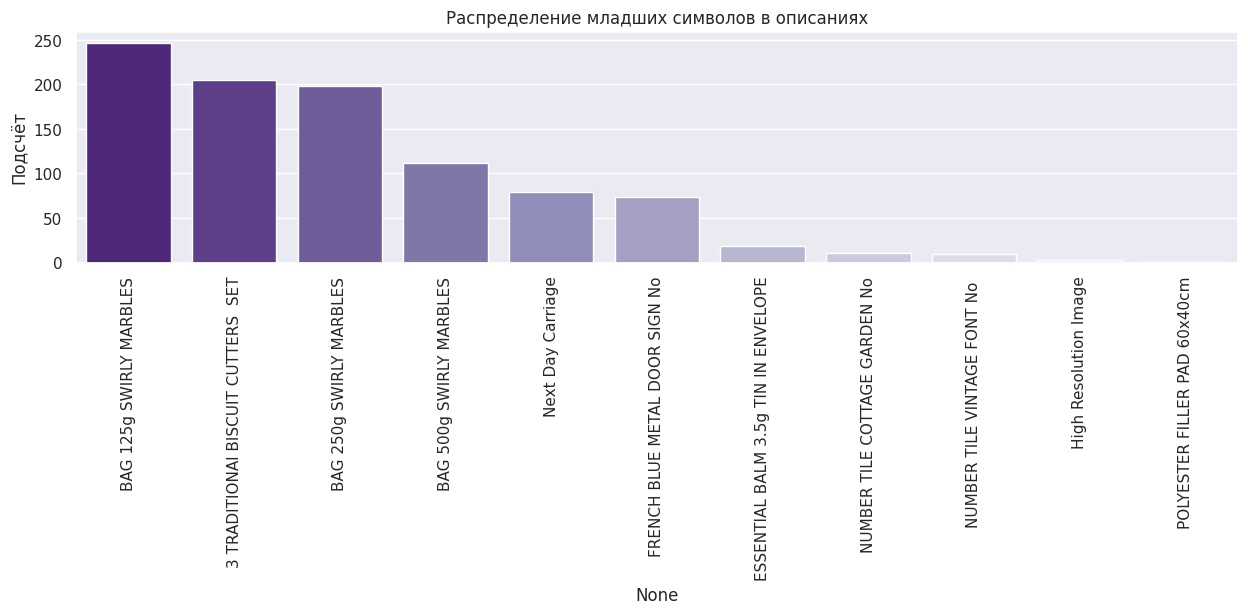

In [ ]:
filtered_data = data[data['LowCharsInDescription'] > 0]

lowchar_counts = filtered_data['Description'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 3))
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")

plt.xticks(rotation=90)
plt.ylabel("Подсчёт")
plt.title("Распределение младших символов в описаниях")

plt.show()

Вычисление доли строчных букв по отношению к прописным

In [ ]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [ ]:
data.UpCharsInDescription.describe()

count    362522.000000
mean         22.572291
std           4.354845
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64

In [ ]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

Next Day Carriage        79
High Resolution Image     3
Name: Description, dtype: int64

Они отличаются от остальных. Удалим их из дата сета

In [ ]:
data = data.loc[data.UpCharsInDescription > 5].copy()

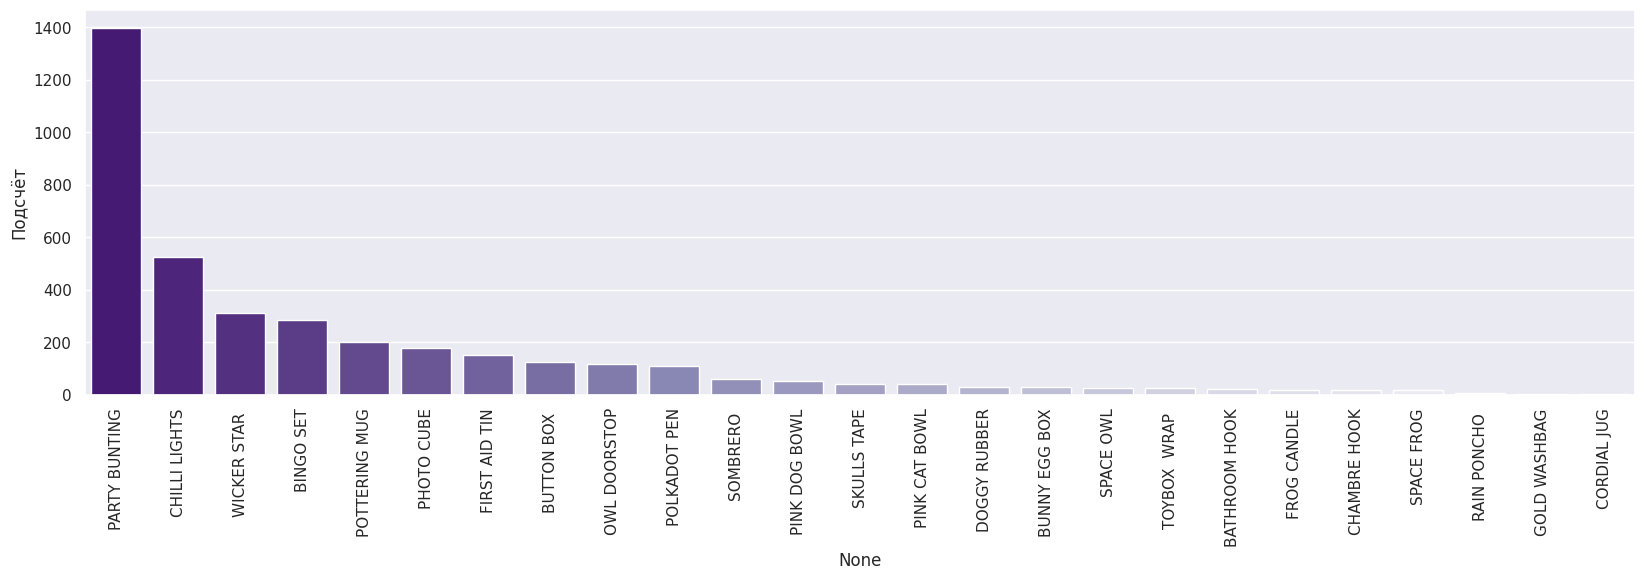

In [ ]:
filtered_data = data[data['DescriptionLength'] < 14]

dlength_counts = filtered_data['Description'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(20, 5))
sns.barplot(x=dlength_counts.index, y=dlength_counts.values, palette="Purples_r")

plt.xticks(rotation=90)
plt.ylabel("Подсчёт")

plt.show()

Описания небольшой длины выглядят корректно, и их не следует отбрасывать. Теперь посмотрим, сколько уникальных биржевых кодов и сколько уникальных описаний

In [ ]:
data.StockCode.nunique()

2781

In [ ]:
data.Description.nunique()

2981

По-прежнему больше описаний, чем кодов акций, и следует продолжать выяснять, почему они различаются.

In [ ]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23236    4
23196    4
23413    3
23244    3
23126    3
23203    3
23209    3
23366    3
23131    3
23535    3
Name: Description, dtype: int64

Все еще есть стоковые коды с несколькими описаниями.

In [ ]:
data.loc[data.StockCode == "23244"].Description.value_counts()

ROUND STORAGE TIN VINTAGE LEAF    96
STORAGE TIN VINTAGE LEAF           7
CANNISTER VINTAGE LEAF DESIGN      2
Name: Description, dtype: int64

StockCode иногда называются немного по-другому из-за пропущенных или измененных слов или ошибок при вводе. Тем не менее, они выглядят нормально

In [ ]:
data.CustomerID.nunique()

4315

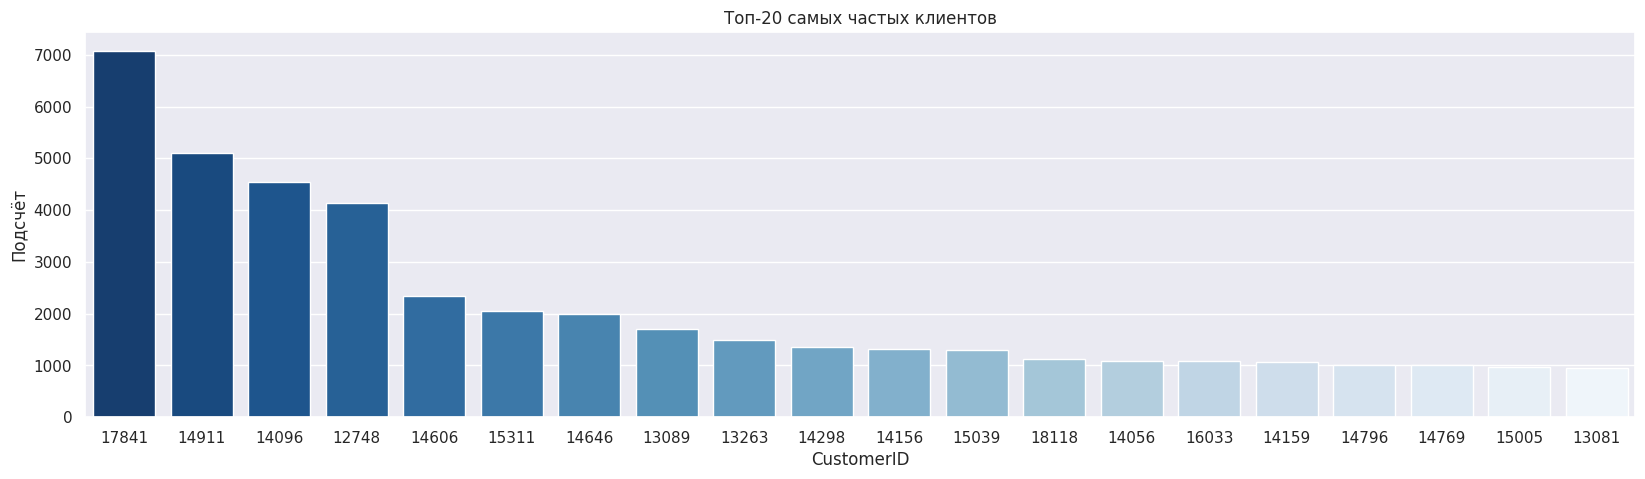

In [ ]:
customer_counts = data['CustomerID'].value_counts().sort_values(ascending=False).iloc[0:20]

plt.figure(figsize=(20, 5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index, palette="Blues_r")

plt.ylabel("Подсчёт")
plt.xlabel("CustomerID")
plt.title("Топ-20 самых частых клиентов")

plt.show()

Во сколько уникальных стран ритейлер доставляет товары

In [ ]:
data.Country.nunique()

37

Какая из них наиболее часто упоминается

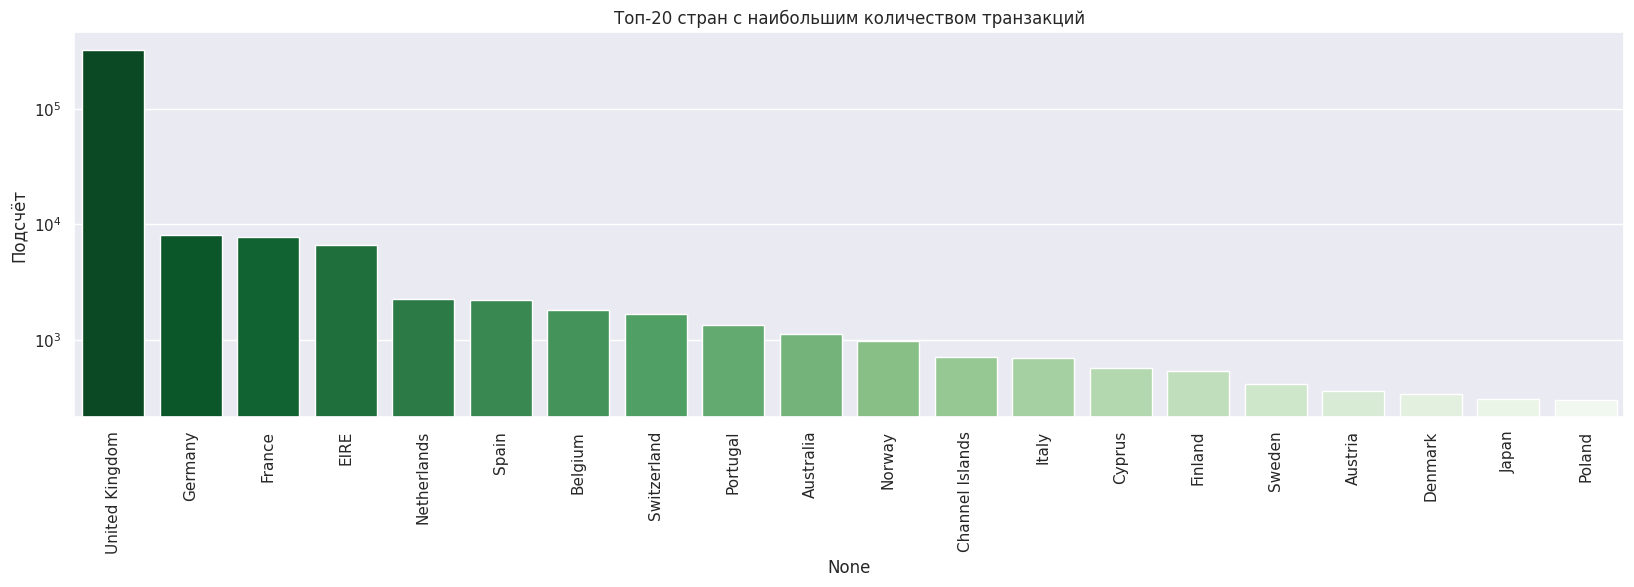

In [ ]:
country_counts = data['Country'].value_counts().sort_values(ascending=False).iloc[0:20]

plt.figure(figsize=(20, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel("Подсчёт")
plt.title("Топ-20 стран с наибольшим количеством транзакций")
plt.xticks(rotation=90)
plt.yscale("log")

plt.show()

Ритейлер продает почти всю продукцию в Великобритании, а затем во многих европейских странах.

In [ ]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

Создам функцию, которая будет указывать доказ в Великобритании или вне

In [ ]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

In [ ]:
data.UnitPrice.describe()

count    362440.000000
mean          2.885355
std           4.361812
min           0.000000
25%           1.250000
50%           1.790000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

Опять есть нулевая стоимость

In [ ]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15,0


Удалим их с дата сета

In [ ]:
data = data.loc[data.UnitPrice > 0].copy()

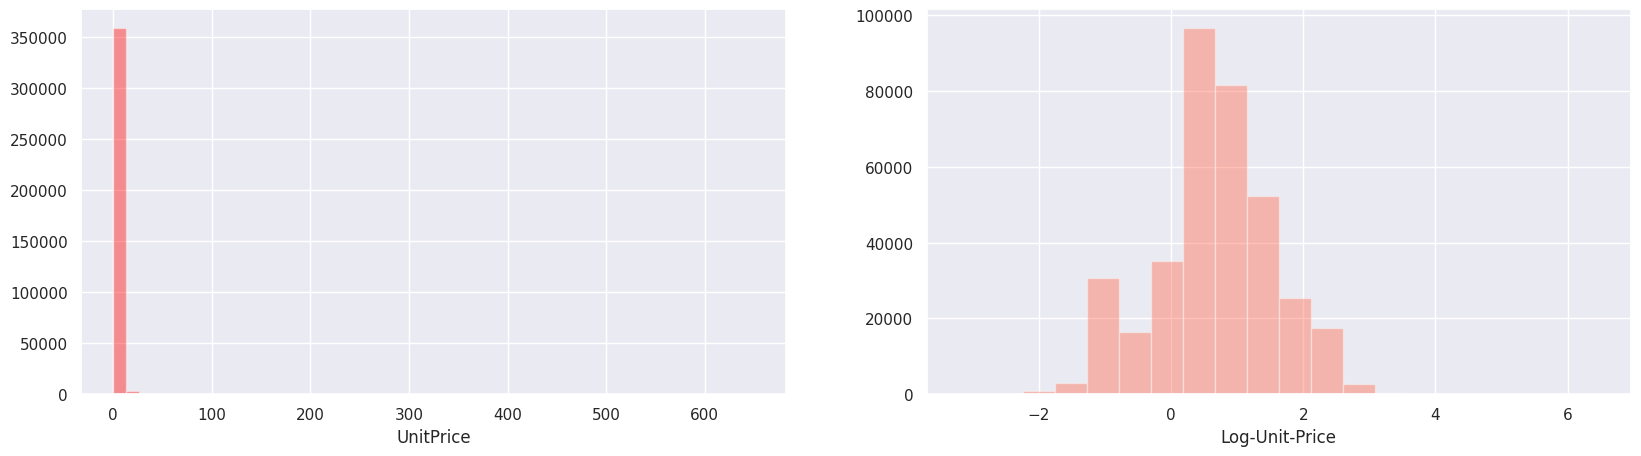

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [ ]:
np.exp(-2)

0.1353352832366127

In [ ]:
np.exp(3)

20.085536923187668

In [ ]:
np.quantile(data.UnitPrice, 0.95)

8.5

In [ ]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

In [ ]:
data.Quantity.describe()

count    361608.000000
mean         13.024112
std         187.566510
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Большинство продуктов продаются в количествах от 1 до 12, но не без аномалий

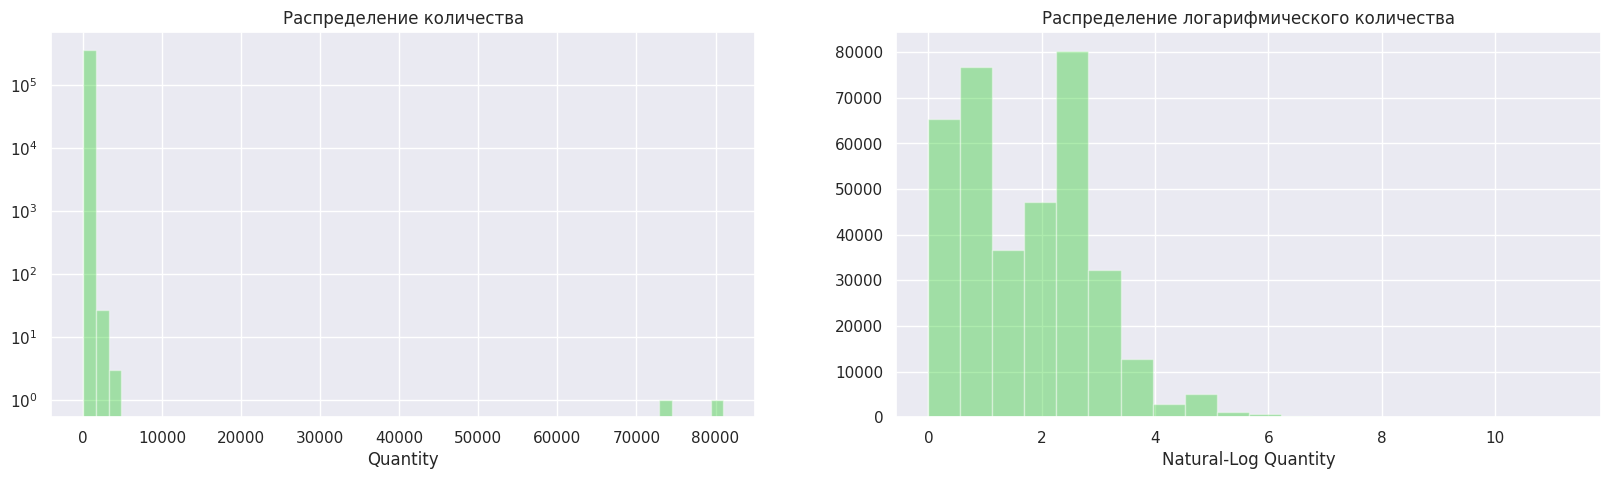

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Распределение количества")
ax[0].set_yscale("log")
ax[1].set_title("Распределение логарифмического количества")
ax[1].set_xlabel("Natural-Log Quantity");

In [ ]:
np.exp(4)

54.598150033144236

In [ ]:
np.quantile(data.Quantity, 0.95)

36.0

С этими преобразованиями охват кода - 95%


In [ ]:
data = data.loc[data.Quantity < 55].copy()

Необходимо вычислить ежедневную совокупность этих данных. Для этого необходимо извлечь временные характеристики из InvoiceDate. Кроме того, можно рассчитать доход, полученный от транзакции, используя цену за единицу и количество.

In [ ]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

Поскольку ключевой задачей этого ядра является прогнозирование количества продуктов, проданных в день, можно суммировать ежедневные количества по каждому складскому коду продукта

In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

Таким образом, потеряется информация о клиентах, странах и ценах, но походу кода она восстановитс. Помимо количества, давайте также совокупируем доходы

In [ ]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


Как объемы и доходы распределяются

In [ ]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [ ]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


In [ ]:
samples = daily_data.shape[0]

In [ ]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

Сколько записей было потерянно?

In [ ]:
samples - daily_data.shape[0]

5258

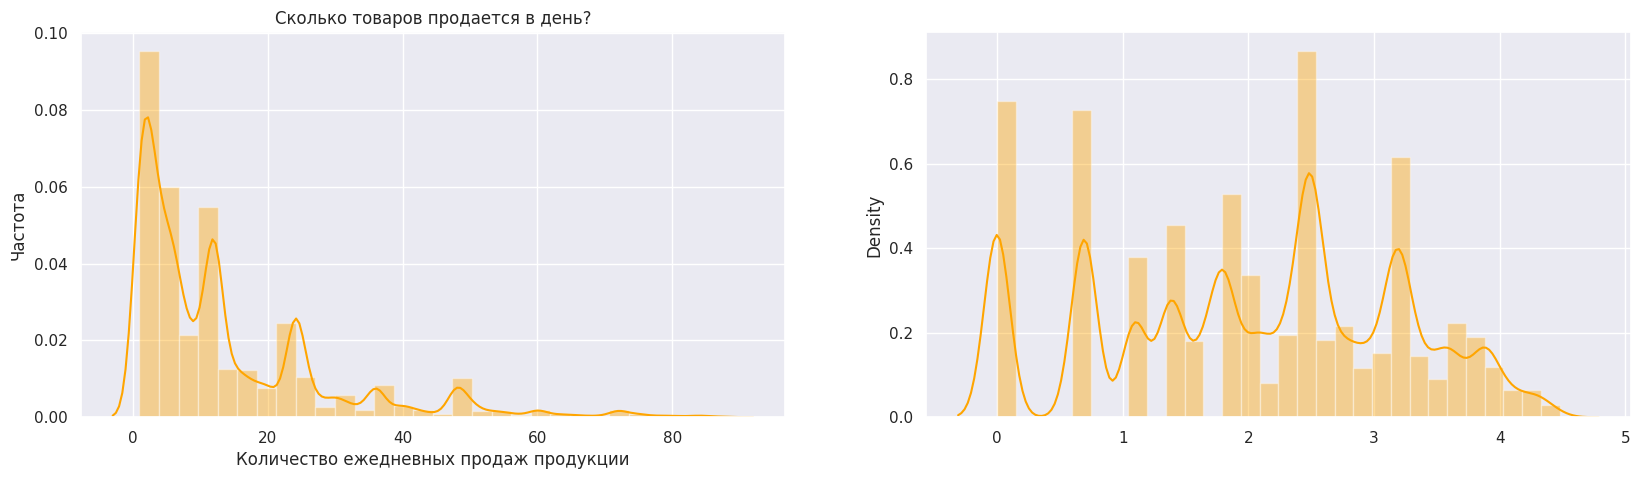

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Количество ежедневных продаж продукции");
ax[0].set_ylabel("Частота");
ax[0].set_title("Сколько товаров продается в день?");

In [ ]:
class CatHyperparameter:

    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

In [ ]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )



In [ ]:
import GPyOpt

class Hypertuner:

    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None

    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()

    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))

    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

In [ ]:
class CatFamily:

    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params

    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)

    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool

    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)

    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score

    def score(self):
        return np.mean(self.model_scores)

    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")



Насколько хорошо эта модель работает без разработки функций и поиска гиперпараметров

In [ ]:
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [ ]:
week = daily_data.Week.max() - 2
print("Проверка через неделю {}".format(week))
print("Проверка начинается в определенный момент времени {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Проверка через неделю 49
Проверка начинается в определенный момент времени 2010-12-06 00:00:00


In [ ]:
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 65


In [ ]:
model.score()

0.20887036435793205

Median absolute error: 0.7892396677686456


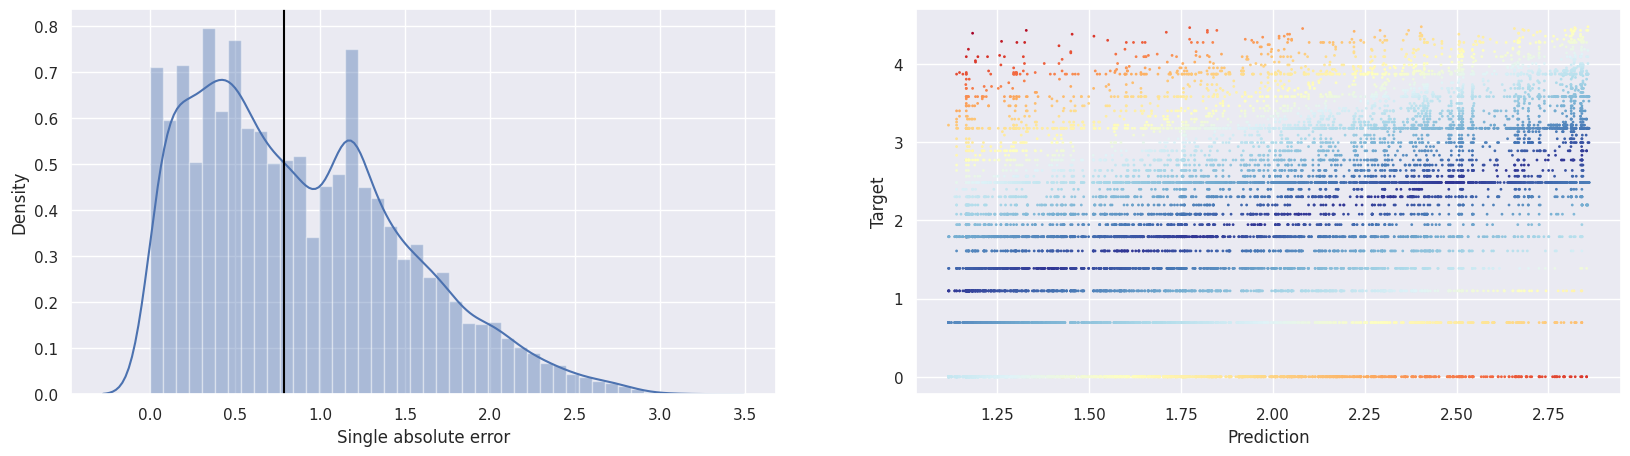

In [ ]:
model.show_val_results();

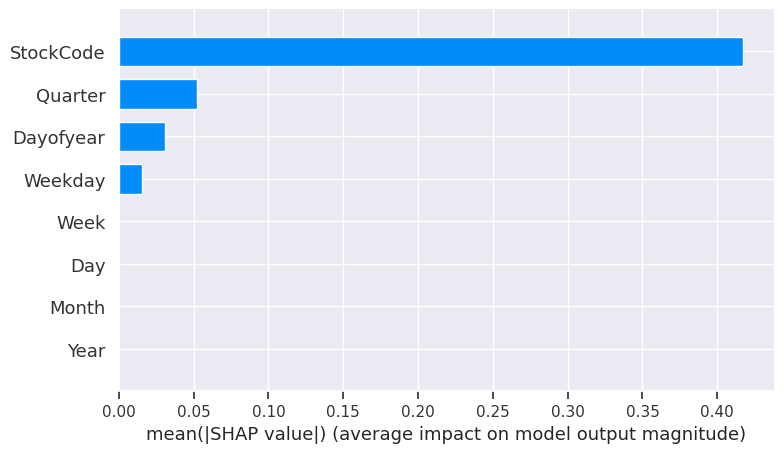

In [ ]:
model.show_importances()

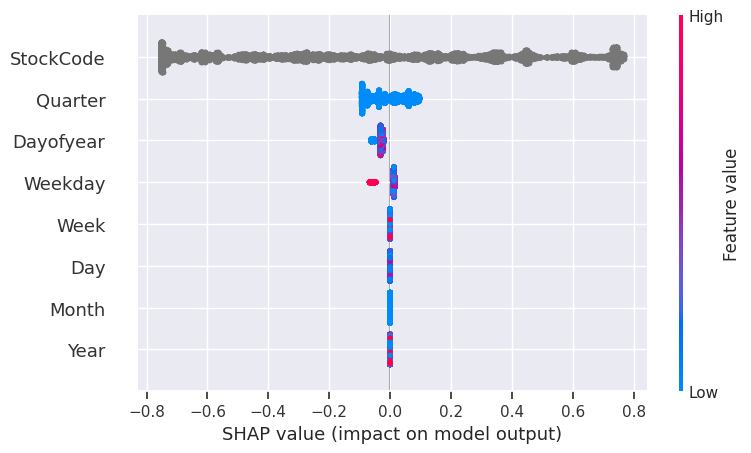

In [ ]:
model.show_importances(kind=None)

In [ ]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

9.70732224604555

In [ ]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

4.77030760517831

In [ ]:
#search = Hypertuner(model, max_depth=5, max_l2_leaf_reg=30)
#search.learn()
#model = search.retrain_catmodel()
#print(model.score())
#model.show_importances(kind=None)

In [ ]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers,DescriptionLength
71053,3.75,4.0,137,19.0
22752,8.50,2.0,163,28.0
21730,4.95,3.0,64,33.0
22633,2.10,4.0,263,22.0
22632,2.10,4.0,227,25.0


In [ ]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]

Text(0, 0.5, 'Boxcox-Median-Quantities')

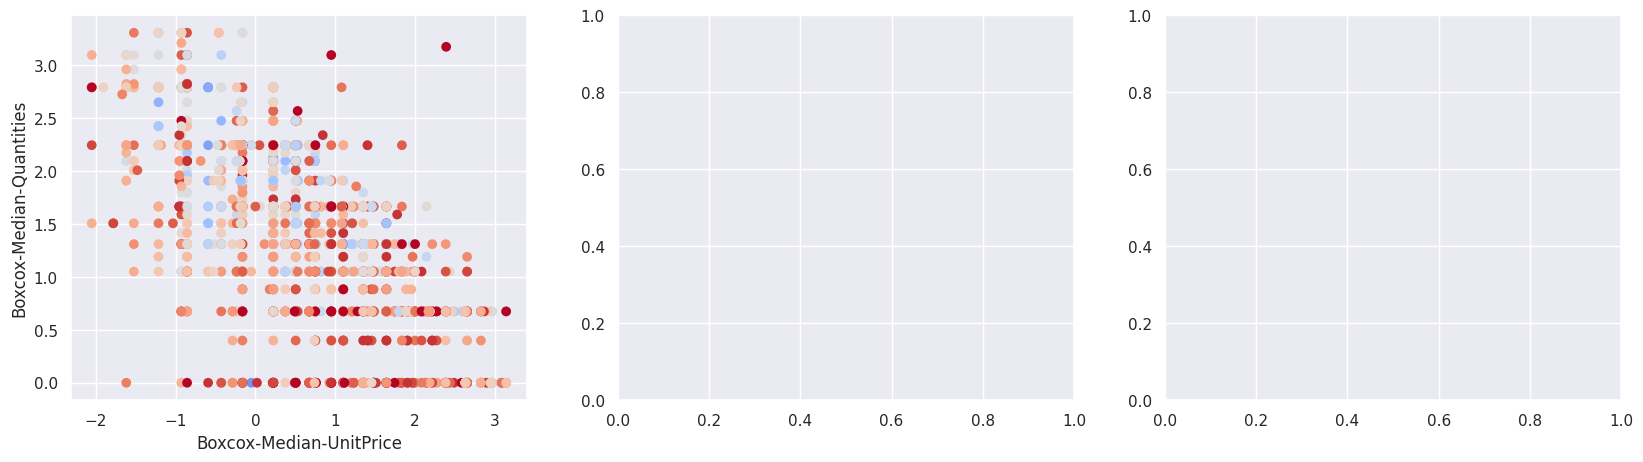

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [ ]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,4.094345,51.00,8.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.693147,1.70,10.0
2,2010-12-01,2010,4,12,48,2,335,1,10133,1.609438,4.25,0.0
3,2010-12-01,2010,4,12,48,2,335,1,16014,2.302585,4.20,8.0
4,2010-12-01,2010,4,12,48,2,335,1,16016,2.302585,8.50,8.0


In [ ]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75)
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25)
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [ ]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [ ]:
daily_data.head()

,StockCode,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,8.0,0.85,0.0000,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,10.0,0.85,0.0000,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,0.0,0.42,0.3225,0.85,0.85,NaN
3,16014,2010,12,48,2,2010-12-01,4,335,1,2.302585,4.20,8.0,0.42,0.0000,0.42,0.42,NaN
4,16016,2010,12,48,2,2010-12-01,4,335,1,2.302585,8.50,8.0,0.85,0.0000,0.85,0.85,NaN


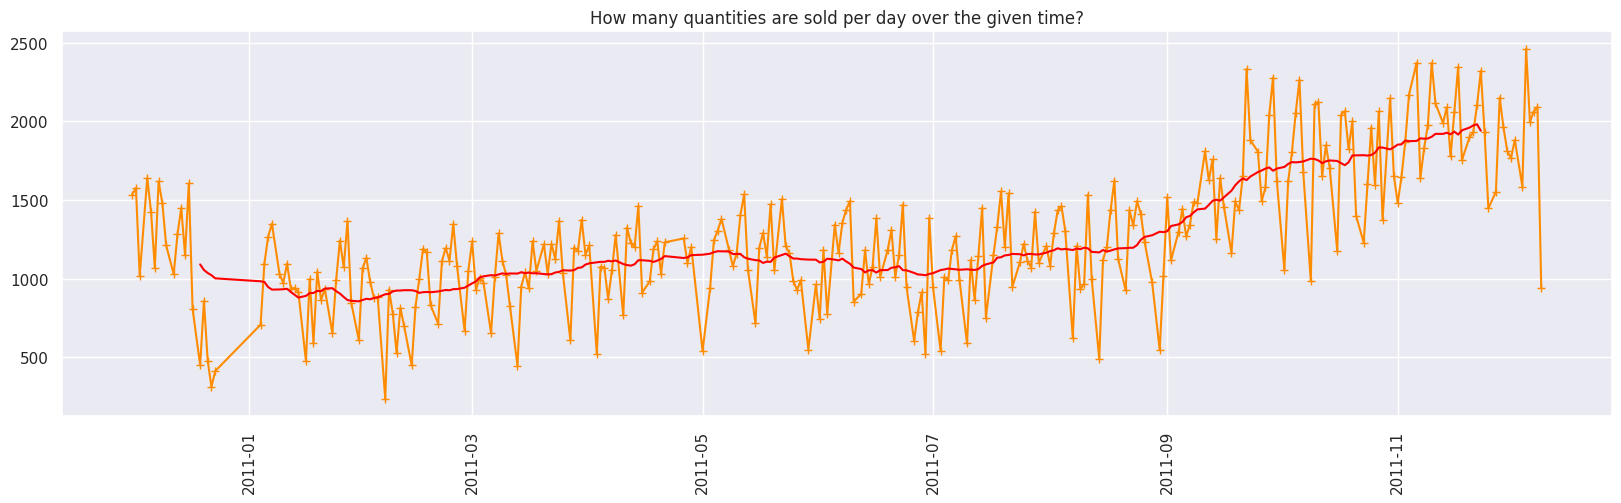

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("Сколько партий продается в день за данный промежуток времени?");

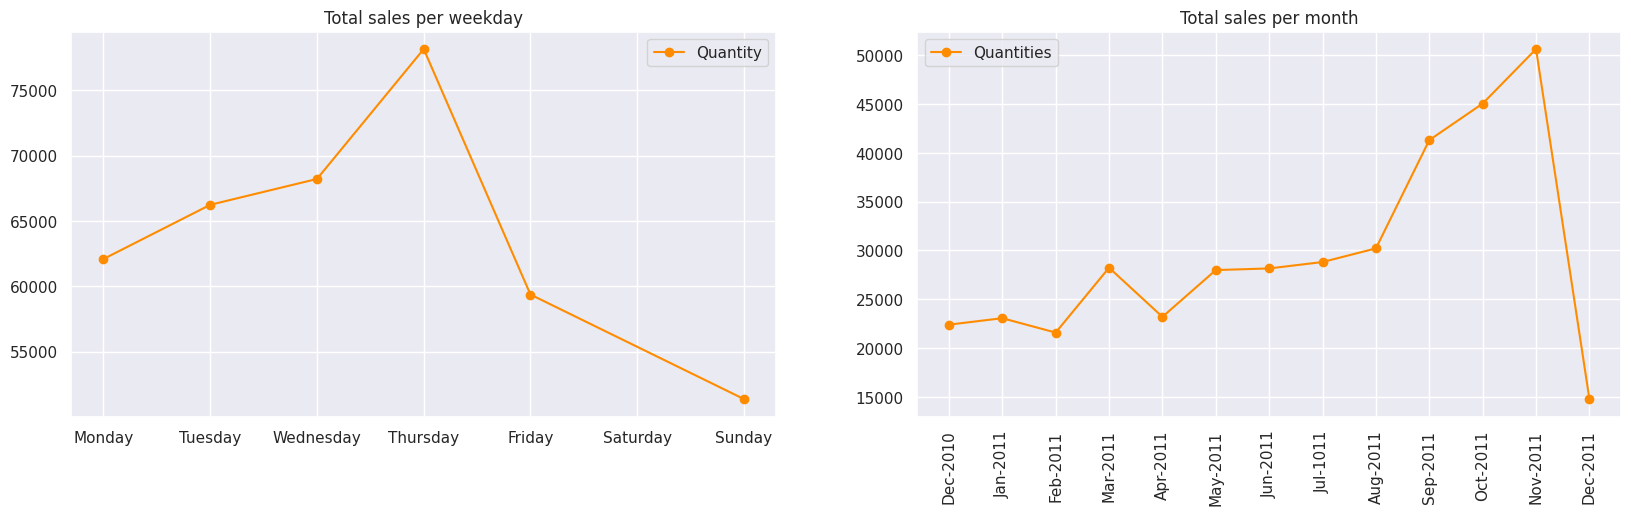

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"]
yearmonth = ["Дек-2010", "Янв-2011", "Фев-2011", "Мар-2011", "Апр-2011", "Май-2011",
             "Июн-2011", "Июл-1011", "Авг-2011", "Сент-2011", "Окт-2011", "Нояб-2011",
             "Дек-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Общий объем продаж за будний день");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Общий объем продаж в месяц");

In [ ]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243)

In [ ]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

,Quarter,Month,Weekday,StockCode,Year,Week,Date,Dayofyear,Day,Quantity,...,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR
0,4,12,2,10002,2010,48,2010-12-01,335,1,4.094345,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
1,4,12,2,10125,2010,48,2010-12-01,335,1,0.693147,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
2,4,12,2,10133,2010,48,2010-12-01,335,1,1.609438,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
3,4,12,2,16014,2010,48,2010-12-01,335,1,2.302585,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712
4,4,12,2,16016,2010,48,2010-12-01,335,1,2.302585,...,-0.240451,1.89712,1.970972,2.079442,-0.108469,1.845827,2.025252,2.079442,-0.054189,1.89712


In [ ]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

In [ ]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)

    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)

    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan


In [ ]:
data["ProductType"] = data.StockCode.map(products.cluster)

In [ ]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())

In [ ]:
delta = 1
to_group = ["Week", "Weekday", "ProductType"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = data.groupby(to_group).CustomerID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [ ]:
daily_data["TransactionsPerStockCode"] = daily_data.StockCode.map(
    data.loc[data.Week < week].groupby("StockCode").InvoiceNo.nunique())

In [ ]:
daily_data.head()

,Week,Weekday,ProductType,StockCode,PreChristmas,Quarter,Month,Year,Date,Dayofyear,...,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerProductType,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerStockCode
0,48,2,8.0,10002,True,4,12,2010,2010-12-01,335,...,1.4,NaN,0.7,NaN,2.3,NaN,3824.0,NaN,NaN,33.0
1,48,2,10.0,10125,True,4,12,2010,2010-12-01,335,...,2.9,NaN,2.5,NaN,1.4,NaN,3871.0,45.0,1.15,50.0
2,48,2,0.0,10133,True,4,12,2010,2010-12-01,335,...,0.5,NaN,3.2,NaN,1.9,NaN,3068.0,37.0,0.76,107.0
3,48,2,8.0,16014,True,4,12,2010,2010-12-01,335,...,1.4,NaN,0.7,NaN,2.3,NaN,3824.0,25.0,0.47,38.0
4,48,2,8.0,16016,True,4,12,2010,2010-12-01,335,...,1.4,NaN,0.7,NaN,2.3,NaN,3824.0,45.0,1.15,53.0


In [ ]:
daily_data["CustomersPerWeekday"] = daily_data.Month.map(
    data.loc[data.Week < week].groupby("Weekday").CustomerID.nunique())

In [ ]:
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 578


In [ ]:
model.score()

0.47267512736614203

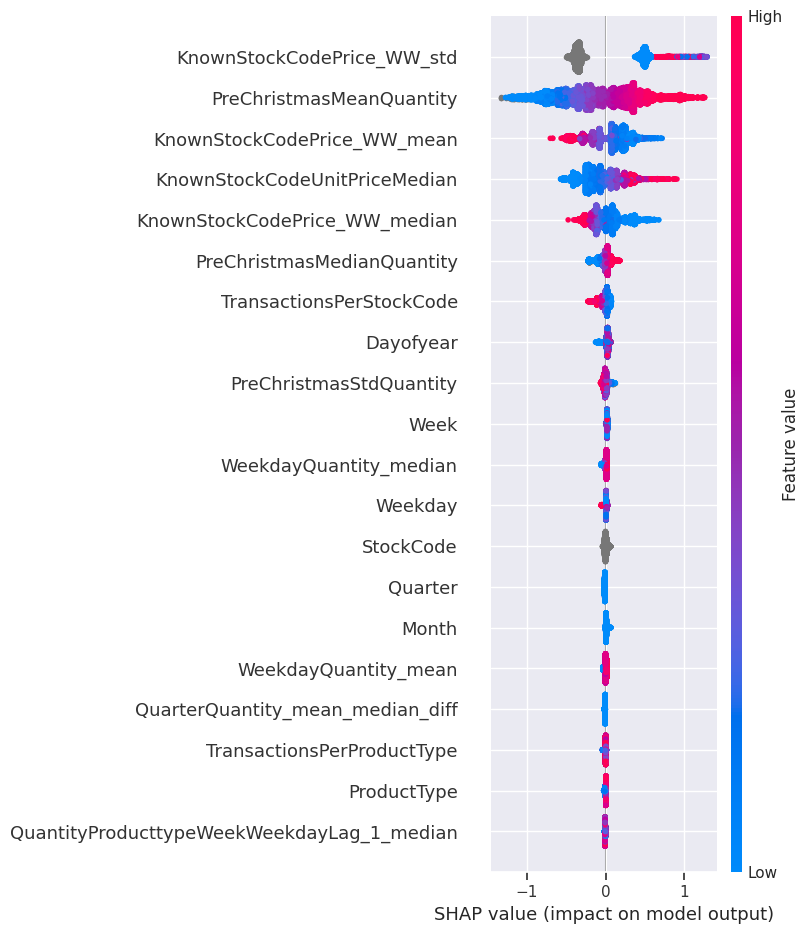

In [ ]:
model.show_importances(kind=None)

Median absolute error: 0.5825418027311413


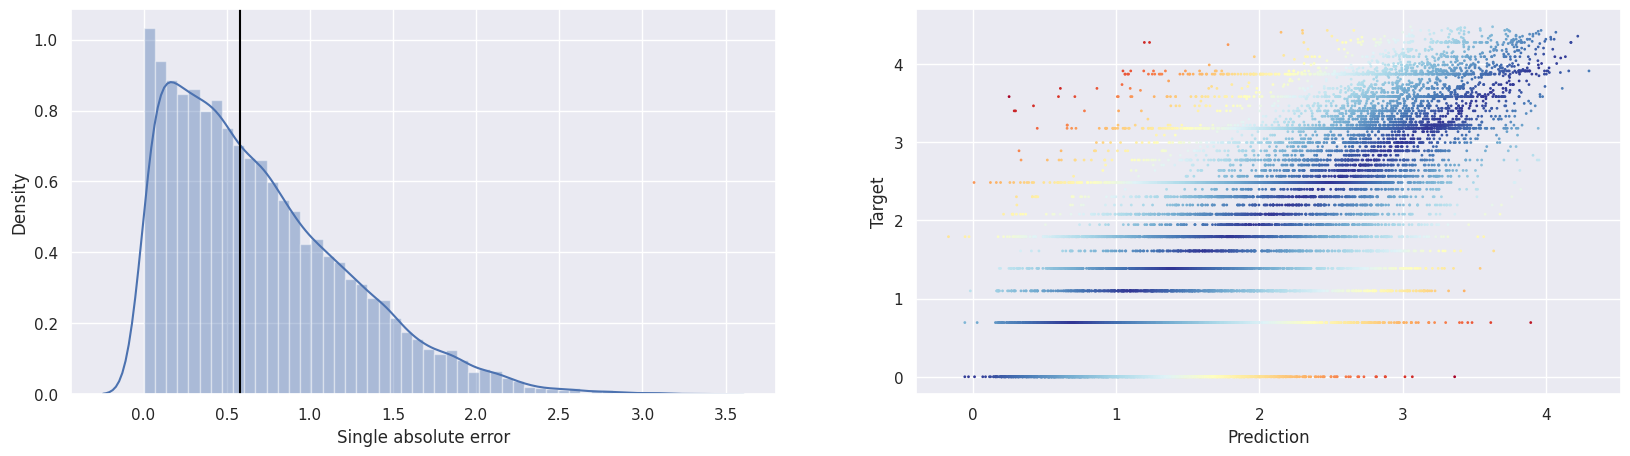

In [ ]:
model.show_val_results();

In [ ]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

7.595057181980013

In [ ]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

4.000351987872797

In [ ]:
search = Hypertuner(model)
#search.learn()

In [ ]:
#model = search.retrain_catmodel()
#print(model.score())

In [ ]:
#model.show_importances(kind=None)